# This kernel detect abusive languages in facebook using RNN models

- author Wen Xie, vaneshieh@gmail.com

In [1]:
from __future__ import print_function
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import keras.backend.tensorflow_backend as KTF
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
config = tf.ConfigProto() 
config.gpu_options.per_process_gpu_memory_fraction = 0.6 # 占用GPU50%的显存 
sess= tf.Session(config=config)
KTF.set_session(sess)

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Bidirectional, TimeDistributed
from keras.layers import Embedding
from keras.layers import LSTM, GRU
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPool1D
from keras.preprocessing.text import Tokenizer
from keras import optimizers
from keras.callbacks import EarlyStopping,ReduceLROnPlateau

import pandas as pd
import numpy as np
import random

from imblearn.over_sampling import SMOTE, ADASYN
from collections import Counter

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


In [12]:
train_data = pd.read_csv('train.csv',encoding='latin-1')
dev_data = pd.read_csv('dev.csv',encoding='latin-1')
test_data = pd.read_csv('test_no_label.csv',encoding='latin-1')

In [13]:
def codelabel(df):
    df['Label'].replace('NAG', 0, inplace=True)
    df['Label'].replace('OAG', 1, inplace=True)
    df['Label'].replace('CAG', 2, inplace=True)
    return df

In [14]:
train_data = codelabel(train_data)
dev_data = codelabel(dev_data)

In [15]:
train_data.head()

,ID,Comment,Label
0,facebook_corpus_msr_1723796,Well said sonu..you have courage to stand agai...,1
1,facebook_corpus_msr_466073,"Most of Private Banks ATM's Like HDFC, ICICI e...",0
2,facebook_corpus_msr_1493901,"Now question is, Pakistan will adhere to this?",1
3,facebook_corpus_msr_405512,Pakistan is comprised of fake muslims who does...,1
4,facebook_corpus_msr_1521685,"??we r against cow slaughter,so of course it w...",0


In [16]:
train_data['Label'].value_counts()

0    5052
2    4240
1    2708
Name: Label, dtype: int64

In [17]:
dev_data.head()

,ID,Comment,Label
0,facebook_corpus_msr_451811,The quality of re made now makes me think it i...,2
1,facebook_corpus_msr_334368,@siva \rHow is ur mother???\rHow is ur wife???...,0
2,facebook_corpus_msr_331195,Also see ....hw ur RSS activist caught in Burk...,0
3,facebook_corpus_msr_403402,On the death of 2 jawans in LOC CROSS FIRING\r...,0
4,facebook_corpus_msr_379239,Modi ho ya Manmohan singh saala yeh log kuch n...,1


In [18]:
train_data['ID'].value_counts()

facebook_corpus_msr_443449     1
facebook_corpus_msr_2082424    1
facebook_corpus_msr_325749     1
facebook_corpus_msr_442952     1
facebook_corpus_msr_2073718    1
                              ..
facebook_corpus_msr_393962     1
facebook_corpus_msr_337217     1
facebook_corpus_msr_410609     1
facebook_corpus_msr_436595     1
facebook_corpus_msr_496789     1
Name: ID, Length: 12000, dtype: int64

In [19]:
X_train = train_data['Comment'].values
y_train = train_data['Label'].values
X_dev = dev_data['Comment'].values
y_dev = dev_data['Label'].values
X_test = test_data['Comment'].values

## Token encoder

In [20]:
tokenizer_obj = Tokenizer()
vocab = list(X_train) + list(X_dev)
tokenizer_obj.fit_on_texts(vocab)

word_index = tokenizer_obj.word_index
print('Found %s unique tokens.' % len(word_index))

#pad sequences
max_length = max([len(s.split()) for s in vocab])
#define vocab size
vocab_size = len(tokenizer_obj.word_index) + 1
#embedding size
embedding_size = 100


X_train_tokens = tokenizer_obj.texts_to_sequences(X_train)
X_dev_tokens = tokenizer_obj.texts_to_sequences(X_dev)
X_test_tokens = tokenizer_obj.texts_to_sequences(X_test)

X_train_pad = sequence.pad_sequences(X_train_tokens,maxlen=max_length,padding='post')
X_dev_pad = sequence.pad_sequences(X_dev_tokens,maxlen=max_length,padding='post')
X_test_pad = sequence.pad_sequences(X_test_tokens,maxlen=max_length,padding='post')

Found 26359 unique tokens.


In [21]:
max_length

1126

In [22]:
vocab_size

26360

In [23]:
X_train_pad

array([[ 131,  155,  358, ...,    0,    0,    0],
       [ 188,    5, 1154, ...,    0,    0,    0],
       [  56,  434,    4, ...,    0,    0,    0],
       ...,
       [5647,  104,    0, ...,    0,    0,    0],
       [ 591,  201,   24, ...,    0,    0,    0],
       [ 735,   42, 7504, ...,    0,    0,    0]])

In [24]:
print('X_train shape:', X_train_pad.shape)
print('y_train shape:', y_train.shape)
print('X_dev shape:', X_dev_pad.shape)
print('y_dev shape:', y_dev.shape)
print('X_tes shape:', X_test.shape)

X_train shape: (12000, 1126)
y_train shape: (12000,)
X_dev shape: (2000, 1126)
y_dev shape: (2000,)
X_tes shape: (1001,)


## Oversampling imbalanced dataset

In [25]:
X_train_pad, y_train = SMOTE().fit_resample(X_train_pad, y_train)
print(sorted(Counter(y_train).items()))

[(0, 5052), (1, 5052), (2, 5052)]


In [26]:
# Convolution
kernel_size = 5
filters = 64
pool_size = 4

## Pretrained embeddings

In [27]:
embeddings_index = {}
f = open('glove.6B.100d.txt', 'r', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [31]:
embeddings_index.get('the')

array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
       -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
        0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
       -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
        0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
       -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
        0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
        0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
       -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
       -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
       -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
       -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
       -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
       -1.2526  ,  0.071624,  0.70565 ,  0.49744 , 

In [29]:
embedding_matrix = np.zeros((len(tokenizer_obj.word_index) + 1, embedding_size ))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [30]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
         0.82779998,  0.27061999],
       [-0.18970001,  0.050024  ,  0.19084001, ..., -0.39804   ,
         0.47646999, -0.15983   ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.50216001, -0.40704   , -0.22932   , ...,  0.13665999,
         0.18063   , -0.14688   ],
       [-0.49950001, -0.78237998, -0.43779999, ...,  0.065569  ,
         1.15569997,  0.53843999]])

## Build model in Keras

In [32]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_length,weights=[embedding_matrix],trainable=False))
model.add(Bidirectional(LSTM(10, dropout=0.3, recurrent_dropout=0.3,return_sequences=True)))
#model.add(Bidirectional(GRU(units=8, dropout=0.3, recurrent_dropout=0.3,return_sequences=True)))
model.add(Bidirectional(LSTM(10, dropout=0.3, recurrent_dropout=0.3,return_sequences=True)))
#model.add(Bidirectional(LSTM(10, dropout=0.3, recurrent_dropout=0.3)))
#model.add(Dropout(0.4))
model.add(Dense(3,activation = 'softmax'))
adam = optimizers.Adam(lr=0.01)
model.compile(loss='sparse_categorical_crossentropy',optimizer=adam, metrics=['sparse_categorical_accuracy'])

In [ ]:
init = tf.global_variables_initializer()
sess.run(init)

print('Train...')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5,min_lr=0.0000001)
es = EarlyStopping(monitor='val_sparse_categorical_accuracy',patience=5,verbose=1,restore_best_weights=True)
model.fit(X_train_pad, y_train,batch_size=256,epochs=40,validation_data=(X_dev_pad, y_dev), callbacks=[es,reduce_lr])

In [39]:
out = model.predict(X_dev_pad)
y_pred = [list(i).index(max(i)) for i in out]
print(classification_report(y_dev, y_pred, target_names=['NAG', 'OAG', 'CAG'],digits=4))
print(['NAG', 'OAG', 'CAG'])
print(confusion_matrix(y_dev, y_pred,labels=[0, 1, 2]))

              precision    recall  f1-score   support

         NAG     0.6861    0.6356    0.6599       815
         OAG     0.4743    0.4000    0.4340       485
         CAG     0.4605    0.5500    0.5013       700

    accuracy                         0.5485      2000
   macro avg     0.5403    0.5285    0.5317      2000
weighted avg     0.5558    0.5485    0.5496      2000

['NAG', 'OAG', 'CAG']
[[518  74 223]
 [ 63 194 228]
 [174 141 385]]


## prediction

In [36]:
y_p = model.predict(X_test_pad)
y_pr = [list(i).index(max(i)) for i in y_p]
test_data['Label'] = y_pr
test_data['Label'].replace(0,'NAG',  inplace=True)
test_data['Label'].replace(1,'OAG',  inplace=True)
test_data['Label'].replace(2,'CAG',  inplace=True)
test_data.head()

,ID,Comment,Label
0,facebook_corpus_msr_495558,But if same had been given before olymic games...,NAG
1,facebook_corpus_msr_1561809,Does our constitution gives power to misbehave...,CAG
2,facebook_corpus_msr_442487,automotive awards are done at the cost of spar...,NAG
3,facebook_corpus_msr_495517,I appreciate the stated facts but the last one...,NAG
4,facebook_corpus_msr_1805455,RSS agent Mr Hazare how you are feeling now?,OAG


In [37]:
test_data.to_csv('test_prediction6.csv',columns=['ID','Label'],index=False)

In [33]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

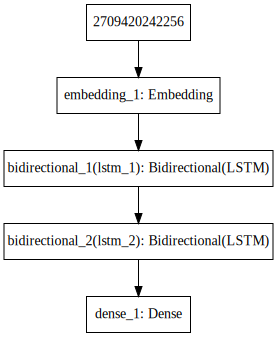

In [36]:
from IPython.display import SVG
#from keras.utils import model_to_dot
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))